In [ ]:
#| default_exp Preprocessing

---
title: "Save workspace variables into Pickle files "
summary: "This notebook shows the pre-processing steps before saving the global variables into either a one-file dataset or each variable in a folder using the `pickle` module."
authors:
  - name: Thomas Guilment
    affiliations:
      - University of Louisiana at Lafayette
    email: thomas.guilment@gmail.com
    corresponding: true
    orcid: 0009-0003-8163-3976
  - name: Gabriele Morra
    affiliations:
      - University of Louisiana at Lafayette
  - name: Orhun Aydin
    affiliations:
      - Saint Louis University
  - name: Stefany Carty
    affiliations:
      - Saint Louis University
format:
  html:
    page-layout: article
    toc: true
    toc-depth: 2
    number-sections: false
jupyter: python3
---

In [ ]:
#| hide
# Import our module
from nautilopy.core import *

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


![](./img/Logo_nautilopy_tiny.png)

# Overview of the pre-processing

```{mermaid}
%%{init: {
  'theme': 'base',
  'themeVariables': {
    'primaryColor': '#3498db',
    'primaryTextColor': '#ffffff',
    'primaryBorderColor': '#2980b9',
    'lineColor': '#2980b9',
    'secondaryColor': '#2ecc71',
    'tertiaryColor': '#f1c40f'
  },
  'flowchart': {
    'nodeSpacing': 50,
    'rankSpacing': 20,
    'padding': 15
  }
}}%%

graph TB
    %% Raw Data
    A[(Raw Data)]

    %% Main Processing Steps
    subgraph DataProcessing ["Data reading"]
        direction TB
        B["Pose and<br/>Navigation"]
        C["Sonar<br/>Data"]
        D["Depth<br/>Sensor"]
        E["DVL<br/>Data"]
    end

    %% Interpolation and Adjustment
    subgraph DataIntegration ["Data Integration & Alignment"]
        direction TB
        F["Position & Euler<br/>Angles Interpolation"]
        G["Dimension<br/>Adjustment"]
        H["Seafloor Map<br/>Data Preparation"]
    end

    %% Cleaning and Correction
    subgraph DataCleaning ["Data Cleaning & Correction"]
        direction TB
        I["Vertical Sonar<br/>Orientation Correction"]
        J["Horizontal Sonar<br/>Noise Reduction"]
        K["Vertical Sonar<br/>Noise Reduction"]
    end

    %% Additional Processing
    L["Depth Profile<br/>Analysis"]
    M["Velocity & Altitude<br/>Processing"]

    %% Data Fusion & Optimization
    N["Data Fusion &<br/>Optimization"]

    %% Data Outputs
    subgraph DataOutputs ["Processed Data Outputs in Pickle format"]
        direction TB
        O["AUV Position &<br/>Orientation"]
        P["Sonar Intensity<br/>Data"]
        Q["Configuration<br/>Parameters"]
        R["Temporal<br/>Information"]
        S["Auxiliary<br/>Parameters"]
    end

    %% Connections
    A --> DataProcessing
    DataProcessing --> DataIntegration
    DataIntegration --> DataCleaning
    DataProcessing --> L & M
    DataCleaning --> N
    L & M --> N
    N --> DataOutputs

    %% Styling
    classDef default fill:#f0f0f0,stroke:#333,stroke-width:1px,font-family:Arial,font-size:12px
    classDef process fill:#3498db,stroke:#2980b9,color:#fff,font-weight:bold
    classDef data fill:#2ecc71,stroke:#27ae60,color:#fff,font-weight:bold
    classDef cleaning fill:#2ecc71,stroke:#27ae60,color:#fff,font-weight:bold
    classDef output fill:#f39c12,stroke:#d35400,color:#fff,font-weight:bold
    classDef subgraphStyle fill:#ecf0f1,stroke:#95a5a6,color:#34495e,font-weight:bold,font-size:14px

    class A data
    class B,C,D,E,F,G,H,L,M,N process
    class I,J,K cleaning
    class O,P,Q,R,S output
    class DataProcessing,DataIntegration,DataCleaning,DataOutputs subgraphStyle
```

## Prepare data for bathymetry

### Pose and Navigation data
Processes pose and navigation data for an Autonomous Underwater Vehicle (AUV):
1. Loads odometry data from a CSV file
2. Extracts 3D position of the AUV
3. Extracts quaternion orientation data
4. Converts quaternions to Euler angles (Yaw, Pitch, Roll)

The resulting data includes:  
- `m_pos_auv`: 3D position matrix  
- `m_quaternion`: Quaternion orientation matrix  
- `l_ypr`: List of Yaw, Pitch, Roll angles  
- `m_ypr`: Matrix of Yaw, Pitch, Roll angles  

In [ ]:
# Data folder path
s_data_folder_path = os.path.join('.', 'data', 'csv')

# 3D position of the AUV
df_odometry = pd.read_csv(s_data_folder_path +'/odometry.csv')
m_pos_auv = df_odometry[['pose.pose.position.x','pose.pose.position.y','pose.pose.position.z']].to_numpy(copy=True)

# 3D orientation from the Quaternions 
df_quaternion_odometry = df_odometry[["pose.pose.orientation.x","pose.pose.orientation.y","pose.pose.orientation.z","pose.pose.orientation.w"]]
m_quaternion = df_quaternion_odometry.to_numpy(copy=True)

# Convert quaternion to Euler angles
l_ypr = []
m_ypr = np.zeros((np.shape(m_quaternion)[0],3))
for index, q in enumerate(m_quaternion):
    roll, pitch, yaw = f_q2rollPitchYaw(q)
    l_ypr.append([yaw,pitch,roll])
    m_ypr[index,:] = np.array([yaw,pitch,roll])


### Position and Euler angles interpolation
Processes and interpolates position and orientation data for two sonars (Micron and SeaKing) on an AUV:

1. Loads data for both sonars and odometry  
2. Extracts timestamps for navigation and both sonars  
3. Interpolates 3D position data to match sonar timestamps  
4. Applies position offsets to account for sonar placement on the AUV  
5. Performs orientation interpolation using Slerp (Spherical Linear Interpolation)  
6. Converts interpolated quaternions to Euler angles (Yaw, Pitch, Roll)  
7. Applies orientation offsets for each sonar  

Key steps:  
- Uses numpy's `interp` function for position interpolation  
- Employs Scipy's `Slerp` for quaternion interpolation  
- Handles timestamp mismatches by trimming sonar data to fit within navigation timestamps  
- Converts quaternions to Euler angles using our `f_q2rollPitchYaw` function  

Key outputs:  
- `m_interp_pos_micron`, `m_interp_pos_seaking`: Interpolated 3D positions for each sonar  
- `m_interp_micron_YPR`, `m_interp_seaking_YPR`: Interpolated and offset-corrected Euler angles for each sonar  
- `v_offset_pos_micron`, `v_offset_pos_seaking`: Position offsets for each sonar  
- `v_offset_ypr_micron`, `v_offset_ypr_seaking`: Orientation offsets for each sonar  

This process ensures accurate alignment of sonar data with the AUV's position and orientation, accounting for the physical placement of sonars on the vehicle.

In [ ]:
# Interpolation of position for both sonar taking the offset into account
# Load the vertical and horizontal mechanical sonars
df_sonar_micron = pd.read_csv(s_data_folder_path + '/sonar_micron.csv')
df_sonar_seaking = pd.read_csv(s_data_folder_path + '/sonar_seaking.csv')
df_odometry = pd.read_csv(s_data_folder_path + '/odometry.csv')

# Extract timestamps
v_timestamp_nav = df_odometry["Time"].to_numpy(copy=True)
v_timestamp_sonar_micron = df_sonar_micron["Time"].to_numpy(copy=True)
v_timestamp_sonar_seaking = df_sonar_seaking["Time"].to_numpy(copy=True)

# 3D position of the AUV
m_pos_auv = df_odometry[['pose.pose.position.x','pose.pose.position.y','pose.pose.position.z']].to_numpy(copy=True)

# Interpolate position to fit the SONAR timestamps dimension
v_interp_micron_x = np.interp(v_timestamp_sonar_micron, v_timestamp_nav, m_pos_auv[:,0], left=None, right=None, period=None)
v_interp_micron_y = np.interp(v_timestamp_sonar_micron, v_timestamp_nav, m_pos_auv[:,1], left=None, right=None, period=None)
v_interp_micron_z = np.interp(v_timestamp_sonar_micron, v_timestamp_nav, m_pos_auv[:,2], left=None, right=None, period=None)

v_interp_seaking_x = np.interp(v_timestamp_sonar_seaking, v_timestamp_nav, m_pos_auv[:,0], left=None, right=None, period=None)
v_interp_seaking_y = np.interp(v_timestamp_sonar_seaking, v_timestamp_nav, m_pos_auv[:,1], left=None, right=None, period=None)
v_interp_seaking_z = np.interp(v_timestamp_sonar_seaking, v_timestamp_nav, m_pos_auv[:,2], left=None, right=None, period=None)

# Concatenate into a matrix
m_interp_pos_micron = np.c_[v_interp_micron_x,v_interp_micron_y,v_interp_micron_z]
m_interp_pos_seaking = np.c_[v_interp_seaking_x,v_interp_seaking_y,v_interp_seaking_z]

# (dx, dy, dz) offset from reference to consider in the 3D sonar position
v_offset_pos_micron = np.array([0.1,0,-0.42])
v_offset_pos_seaking = np.array([0.55,0,0.15])

v_offset_ypr_micron = np.array([np.pi,0,0])
v_offset_ypr_seaking = np.array([np.pi,np.pi/2,0])

# Use of broadcasting to correct the position
m_interp_pos_micron += v_offset_pos_micron # Here the negative z value makes sense, we will change the z coordinates to -z for plotting later
m_interp_pos_seaking += v_offset_pos_seaking


In [ ]:
# Interpolation with Scipy
r_ypr_odometry = R.from_quat(m_quaternion)

# Slerp algorithm
slerp = Slerp(v_timestamp_nav,r_ypr_odometry)

# Interpolate for the new timestamps

# The timestamp of Micron and Seaking are bigger and this raises a ValueError as the interpolation becomes an extrapolation.
# We decide to remove the beginning and end part of the survey from the sonar timestamps to fit inside the navigation timestamps for now.
d_min_thresh = v_timestamp_nav[0]
d_max_thresh = v_timestamp_nav[-1]

d_ind_min_micron = sum(v_timestamp_sonar_micron < d_min_thresh)
d_ind_max_micron = len(v_timestamp_sonar_micron) - sum(v_timestamp_sonar_micron > d_max_thresh)

d_ind_min_seaking = sum(v_timestamp_sonar_seaking < d_min_thresh)
d_ind_max_seaking = len(v_timestamp_sonar_seaking) -  sum(v_timestamp_sonar_seaking > d_max_thresh)

# v_timestamp_sonar_micron = np.delete(v_timestamp_sonar_micron,v_timestamp_sonar_micron < d_min_thresh)
# v_timestamp_sonar_micron = np.delete(v_timestamp_sonar_micron,v_timestamp_sonar_micron > d_max_thresh)

r_interp_ypr_odometry_micron = slerp(v_timestamp_sonar_micron[d_ind_min_micron:d_ind_max_micron])
r_interp_ypr_odometry_seaking = slerp(v_timestamp_sonar_seaking[d_ind_min_seaking:d_ind_max_seaking])

# Convert quaternion to Euler angles
l_yaw_pitch_roll = []
m_interp_micron_YPR = np.zeros((np.shape(r_interp_ypr_odometry_micron.as_quat())[0],3))
m_interp_seaking_YPR = np.zeros((np.shape(r_interp_ypr_odometry_seaking.as_quat())[0],3))

for index, q in enumerate(r_interp_ypr_odometry_micron.as_quat()):
    roll, pitch, yaw = f_q2rollPitchYaw(q)
    l_yaw_pitch_roll.append([yaw,pitch,roll])
    m_interp_micron_YPR[index,:] = np.array([yaw,pitch,roll])

for index, q in enumerate(r_interp_ypr_odometry_seaking.as_quat()):
    roll, pitch, yaw = f_q2rollPitchYaw(q)
    l_yaw_pitch_roll.append([yaw,pitch,roll])
    m_interp_seaking_YPR[index,:] = np.array([yaw,pitch,roll])

# m_interp_micron_YPR = r_interp_ypr_odometry_micron.as_euler('ZYX')
# m_interp_seaking_YPR = r_interp_ypr_odometry_seaking.as_euler('ZYX')

# Final Euler angle with offset compensation
m_interp_micron_YPR -= v_offset_ypr_micron
m_interp_seaking_YPR -= v_offset_ypr_seaking

### Dimension adjustment
Adjusts the dimensions of the sonar data to ensure consistency with the interpolated navigation data:  

1. Trims the interpolated position data for both Micron and SeaKing sonars  
2. Extracts beam data from the sonar DataFrames  
3. Converts beam data to numpy arrays for efficient processing  
4. Adjusts the dimensions of the sonar intensity data to match the trimmed navigation data  
5. Trims the sonar timestamps to match the adjusted data  

Key operations:  
- Uses array slicing to trim data (`[d_ind_min:d_ind_max]`)  
- Extracts beam data columns using list comprehension  
- Transposes sonar intensity matrices for consistent orientation  

Key outputs:  
- `m_interp_pos_micron_final`, `m_interp_pos_seaking_final`: Trimmed interpolated positions  
- `m_sonarReceivedIntensity_micron_final`, `m_sonarReceivedIntensity_seaking_final`: Adjusted sonar intensity data  
- `v_timestamp_sonar_micron_final`, `v_timestamp_sonar_seaking_final`: Trimmed sonar timestamps  

This dimension adjustment ensures that all data arrays (position, orientation, intensity, and timestamps) are aligned and have consistent sizes.

In [ ]:
# Position
m_interp_pos_micron_final = m_interp_pos_micron[d_ind_min_micron:d_ind_max_micron,:].copy()
m_interp_pos_seaking_final = m_interp_pos_seaking[d_ind_min_seaking:d_ind_max_seaking,:].copy()

# Extract the beam data and vizualize it in 2D like an image
df_beam_data_micron = df_sonar_micron[[col for col in df_sonar_micron.columns if col.startswith('beam_data')]].copy()
df_beam_data_seaking = df_sonar_seaking[[col for col in df_sonar_seaking.columns if col.startswith('beam_data')]].copy()

# Conversion to numpy ndarray
m_sonarReceivedIntensity_micron = df_beam_data_micron.to_numpy(copy=True)
m_sonarReceivedIntensity_seaking = df_beam_data_seaking.to_numpy(copy=True)

# Dimension adjustement
m_sonarReceivedIntensity_micron_final = m_sonarReceivedIntensity_micron[d_ind_min_micron:d_ind_max_micron,:].copy().T
m_sonarReceivedIntensity_seaking_final = m_sonarReceivedIntensity_seaking[d_ind_min_seaking:d_ind_max_seaking,:].copy().T

v_timestamp_sonar_micron_final = v_timestamp_sonar_micron[d_ind_min_micron:d_ind_max_micron]
v_timestamp_sonar_seaking_final = v_timestamp_sonar_seaking[d_ind_min_seaking:d_ind_max_seaking]

### Additional data for seafloor map creation
Prepares additional data necessary for creating a seafloor map from sonar readings:

1. Defines range vectors for both Micron and SeaKing sonars
2. Extracts scanning angles from sonar data
3. Adjusts dimensions of angle data to match previously trimmed datasets

Key points:  
- Range vectors are created using `np.linspace`:  
  - Micron sonar: 0 to 20 meters (397 points)  
  - SeaKing sonar: 0 to 10 meters (50 points)  
- Scanning angles are extracted in radians  
- Dimensions of angle data are adjusted to match previously trimmed datasets  

Key outputs:  
- `v_range_micron`, `v_range_seaking`: Range vectors for each sonar  
- `v_angles_rad_micron_final`, `v_angles_rad_seaking_final`: Trimmed scanning angle data  


::: {.callout-warning}
#### Note: There's a discrepancy between the article's stated ranges and the actual data ranges:  
- Micron: Article states 50 meters, data shows 20 meters  
- SeaKing: Article states 20 meters, data shows 10 meters
  
:::

In [ ]:
# Estimated range per beam in meter
# Convert energy per distance into estimated range
# Attention, the article says 50 meters and the data says 20 meters
v_range_micron = np.linspace(0,20,397)

# Same the article says 20 when the data shows 10 meters
v_range_seaking = np.linspace(0,10,50)

# Scanning angles in radian
v_angles_rad_micron = df_sonar_micron["angle_rad"].to_numpy(copy=True)
v_angles_rad_seaking = df_sonar_seaking["angle_rad"].to_numpy(copy=True)

# Dimension adjustment
v_angles_rad_micron_final = v_angles_rad_micron[d_ind_min_micron:d_ind_max_micron].copy()
v_angles_rad_seaking_final = v_angles_rad_seaking[d_ind_min_seaking:d_ind_max_seaking].copy()

## Correction of the Vertical Sonar Orientation

Correction to the orientation data of the vertical sonar (SeaKing):  

1. Adjusts the Yaw-Pitch-Roll (YPR) data for the SeaKing sonar  
2. Adds a rotation of π radians (180 degrees) to the pitch angle  

::: {.callout-important}
#### Explanation
- The vertical sonar's actual orientation differs from the initially assumed configuration on the AUV  
- This correction rotates the sonar's orientation by 180 degrees around the pitch axis  
- The adjustment ensures accurate interpretation of the vertical sonar data in subsequent processing steps

:::

::: {.callout-note}
This correction is neccessary for properly aligning the vertical sonar data with the AUV's frame of reference and the seafloor topography.
:::

In [ ]:
m_interp_seaking_YPR = m_interp_seaking_YPR+np.array([0,np.pi,0])

## Add cleaned data

### Cleaning the horizontal sonar
1. Creates a copy of the original data for cleaning  
2. Removes constant noise lines from the front and back of the AUV detection range  
3. Applies a mask to remove background noise in specific regions  
4. Implements a periodic cleaning process to address cyclic noise patterns  
5. Applies hysteresis thresholding for further noise reduction  

Key operations:  
- Removes constant noise in the first 9 rows  
- Uses a 200-step loop to clean periodic noise patterns  
- Applies custom hysteresis thresholding function `f_hyster`  

Outputs:  
- `m_sonar_micron_clean_hyst`: Cleaned horizontal sonar data  

In [ ]:
m_sonar_micron_clean = m_sonarReceivedIntensity_micron_final.copy()

# Selected part where the walls are far from the front and back AUV detection
m_mask_instensity_back = m_sonarReceivedIntensity_micron_final[0:70, 594 - 35 : 594 + 35].copy()
d_length_back_beam = 70
d_length_back_start = -35
d_length_back_end = 35

m_mask_intensity_front = m_sonarReceivedIntensity_micron_final[0:30, 4064:4134]
d_length_front_start = -35
d_length_front_end = 35
d_length_front_beam = 30

# remove the constant line
m_sonar_micron_clean[0:9, :] = 0

# First-period index
d_first_period = 194  # Angle = 0°
d_first_half_period = 94

# Loop to remove the 
for d_ind in range(d_first_period, np.shape(m_sonar_micron_clean)[1], 200):
    m_aux = m_sonar_micron_clean[0:d_length_back_beam, d_ind + d_length_back_start : d_ind + d_length_back_end].copy()
    m_aux -= m_mask_instensity_back
    m_aux[m_aux <= 0] = 0
    m_sonar_micron_clean[0:d_length_back_beam, d_ind + d_length_back_start : d_ind + d_length_back_end] = m_aux.copy()

    m_aux_front = m_sonar_micron_clean[0:d_length_front_beam, d_ind - 100 + d_length_front_start : d_ind - 100 + d_length_front_end].copy()
    m_aux_front -= m_mask_intensity_front
    m_aux_front[m_aux_front <= 0] = 0
    m_sonar_micron_clean[0:d_length_front_beam, d_ind - 100 + d_length_front_start : d_ind - 100 + d_length_front_end] = m_aux_front

# Apply the hysteresis thresholding
m_sonar_micron_clean_hyst = f_hyster(m_sonar_micron_clean, 0.4, 0.7, d_overlap=0.5, d_window_size=100)


### Cleaning the vertical sonar
1. Creates a copy of the original data  
2. Removes noise lines from the first two rows  
3. Applies hysteresis thresholding for noise reduction  

Outputs:  
- `m_sonar_micron_clean_hyst`: Cleaned horizontal sonar data  
- `m_sonar_seaking_clean_hyst`: Cleaned vertical sonar data  

::: {.callout-note}
The horizontal sonar's cleaning process is more extensive due to its more complex noise patterns. The hysteresis thresholding parameters are adjusted differently for each sonar type to optimize noise reduction while preserving important features.
:::

In [ ]:
m_sonar_seaking_clean = m_sonarReceivedIntensity_seaking_final.copy()

# Remove the line
m_sonar_seaking_clean[0:2, :] = 0

# Apply the hysteresis thresholding
m_sonar_seaking_clean_hyst = f_hyster(m_sonar_seaking_clean, 0.3, 0.9, d_overlap=0.5, d_window_size=2)

## Processing Depth Sensor Data

Handles the depth sensor data, which measures the AUV's depth in the water column. The process includes:

1. Loading depth sensor data from a CSV file  
2. Extracting the depth measurements into a NumPy array  
3. Visualizing the depth profile  

Key points:  
- The depth values are negated in the plot to show increasing depth downwards, which is the conventional representation in oceanography  
- This data complements the DVL-derived depth estimates and provides a more accurate depth profile of the AUV's trajectory  

Comparing this direct depth measurement with the DVL-derived depth estimate can help validate the data and provide a more comprehensive understanding of the AUV's vertical movement during the mission.

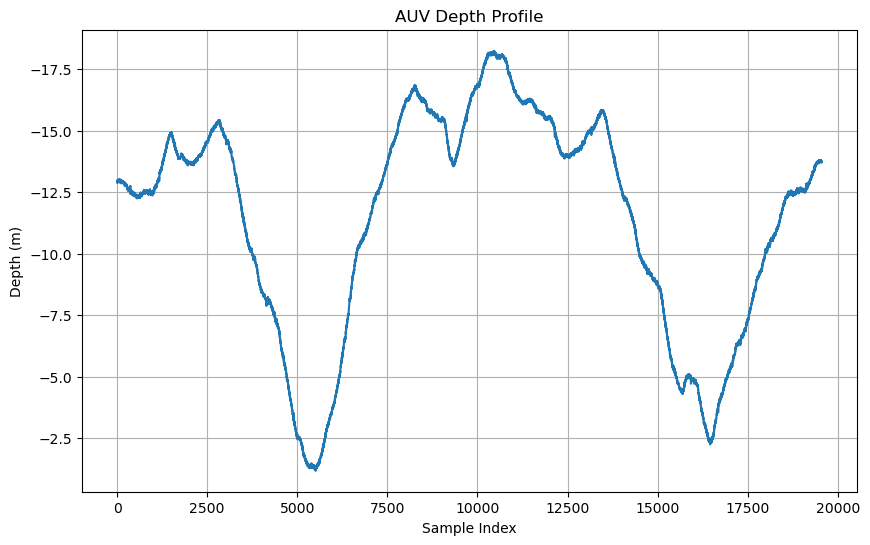

In [ ]:
# Load depth sensor data
df_depth = pd.read_csv(s_data_folder_path + '/depth_sensor.csv')
v_depth = df_depth['depth'].to_numpy(copy=True)
v_timestamp_depth = df_depth['Time'].to_numpy(copy=True)

# Visualize depth profile
plt.figure(figsize=(10, 6))
plt.plot(-v_depth)
plt.title("AUV Depth Profile")
plt.xlabel("Sample Index")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()  # Invert y-axis to show increasing depth downwards
plt.grid(True)
plt.show()

## Processing Doppler Velocity Log (DVL) Data

Processes data from the Doppler Velocity Log (DVL) sensor, which provides information about the AUV's velocity and altitude relative to the seafloor. The processing includes:  

1. Loading DVL data from a CSV file  
2. Extracting timestamps and altitude measurements  
3. Cleaning and interpolating altitude data to remove invalid measurements  
4. Processing velocity data in X, Y, and Z directions  
5. Interpolating missing velocity values  
6. Visualizing the processed data for verification  

Key operations:  
- Linear interpolation to replace invalid altitude measurements  
- Handling of edge cases in velocity data where all components are zero  
- Cumulative sum of Z-velocity to estimate depth profile  

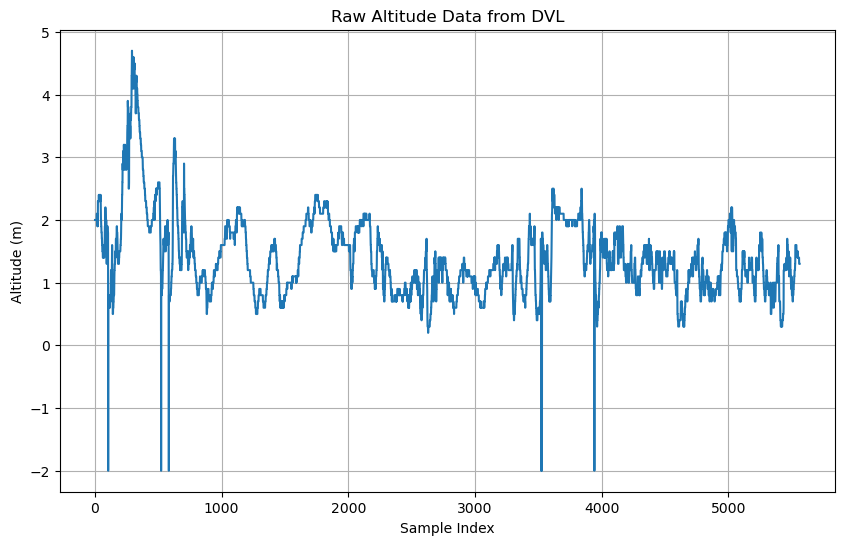

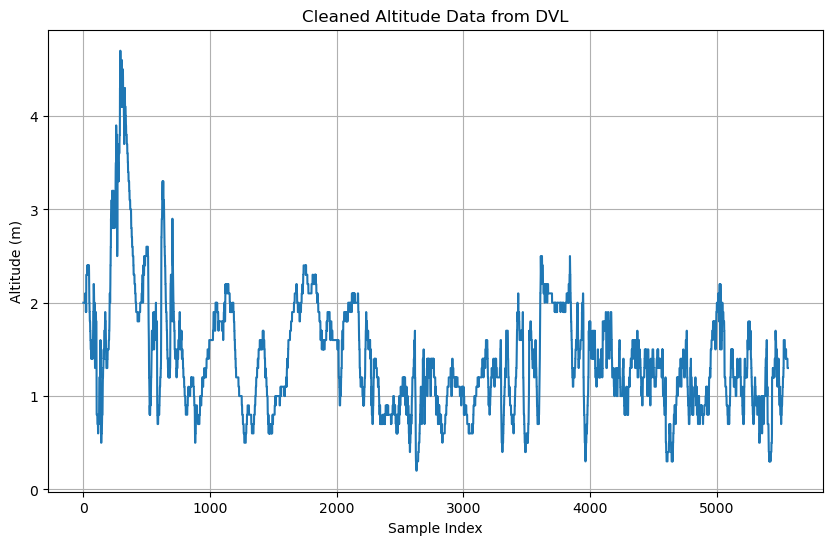

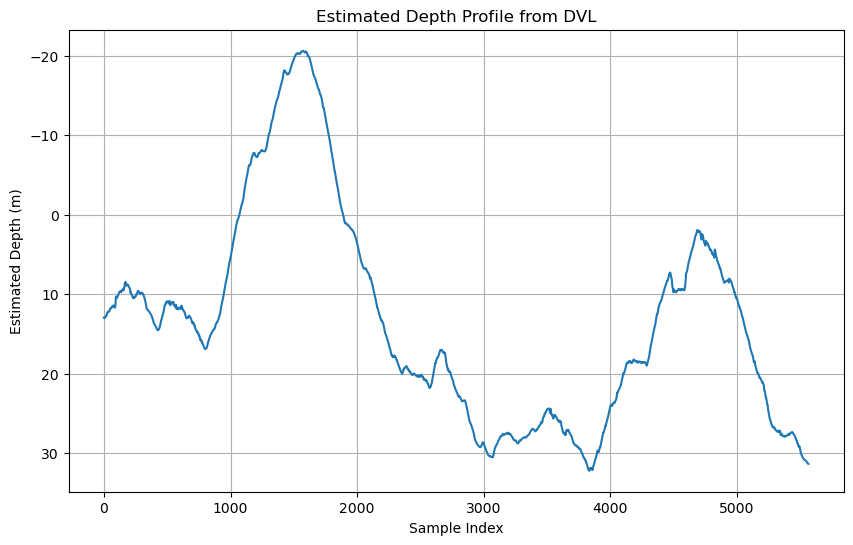

In [ ]:
## Add Doppler velocity sensor data

# Load DVL data
df_dvl = pd.read_csv(s_data_folder_path + '/dvl_linkquest.csv')
v_timestamp_dvl = df_dvl['Time'].to_numpy(copy=True)
v_altitude_seafloor = df_dvl['altitude'].to_numpy(copy=True)

# Visualize raw altitude data
plt.figure(figsize=(10, 6))
plt.plot(v_altitude_seafloor)
plt.title("Raw Altitude Data from DVL")
plt.xlabel("Sample Index")
plt.ylabel("Altitude (m)")
plt.grid(True)
plt.show()

# Clean and interpolate altitude data
indices_to_replace = np.where(v_altitude_seafloor < 0)[0]
for i in indices_to_replace:
    if i == 0:
        v_altitude_seafloor[i] = v_altitude_seafloor[i+1]
    elif i == len(v_altitude_seafloor) - 1:
        v_altitude_seafloor[i] = v_altitude_seafloor[i-1]
    else:
        v_altitude_seafloor[i] = (v_altitude_seafloor[i-1] + v_altitude_seafloor[i+1]) / 2

# Visualize cleaned altitude data
plt.figure(figsize=(10, 6))
plt.plot(v_altitude_seafloor)
plt.title("Cleaned Altitude Data from DVL")
plt.xlabel("Sample Index")
plt.ylabel("Altitude (m)")
plt.grid(True)
plt.show()

# Process velocity data
m_velocityInst_xyz = df_dvl[['velocityInst_0', 'velocityInst_1', 'velocityInst_2']].to_numpy(copy=True)

# Interpolate missing velocity values
zero_velocity_indices = np.where((m_velocityInst_xyz == 0).all(axis=1))[0]
for index in zero_velocity_indices:
    if index == 0:
        m_velocityInst_xyz[index] = m_velocityInst_xyz[index+1]
    elif index == len(m_velocityInst_xyz) - 1:
        m_velocityInst_xyz[index] = m_velocityInst_xyz[index-1]
    else:
        m_velocityInst_xyz[index] = (m_velocityInst_xyz[index-1] + m_velocityInst_xyz[index+1]) / 2

# Visualize depth profile estimation
plt.figure(figsize=(10, 6))
estimated_depth = np.cumsum(m_velocityInst_xyz[:, 2]) - v_depth[0]
plt.plot(-estimated_depth)  # Negate to show depth increasing downwards
plt.title("Estimated Depth Profile from DVL")
plt.xlabel("Sample Index")
plt.ylabel("Estimated Depth (m)")
plt.gca().invert_yaxis()  # Invert y-axis to show increasing depth downwards
plt.grid(True)
plt.show()

## "Optimized" Saving of Processed AUV and Sonar Data
Save each variable separately to optimize storage space usage.

Function Used:  
   - `f_save_var`: A custom function designed to save variables individually.  
   - The function likely creates separate files for each variable, possibly with compression.  

Save Location:  
   - Data is saved to the '../data/Pickle_dataset' directory.  
   - Each variable is created inside this directory.  

Data Saved:  
   - AUV position and orientation data (e.g., 'm_interp_micron_YPR', 'm_pos_auv')  
   - Sonar intensity data, both raw and processed (e.g., 'm_sonarReceivedIntensity_micron_final', 'm_sonar_micron_clean_hyst')  
   - Configuration data (e.g., 'v_angles_rad_micron_final', 'v_range_micron')  
   - Timestamp information (e.g., 'v_timestamp_nav', 'v_timestamp_sonar_micron_final')  
   - Other relevant parameters and paths  



In [ ]:
if not os.path.exists('../data/Pickle_dataset'):
    
    # If needed save each variable separately to optimize space uses
    f_save_var('../data/Pickle_dataset', globals(), 
         'm_interp_micron_YPR',
         'm_interp_pos_micron_final',
         'm_interp_pos_seaking_final',
         'm_interp_seaking_YPR',
         'm_pos_auv',
         'm_ypr',
         'm_sonarReceivedIntensity_micron_final',
         'm_sonarReceivedIntensity_seaking_final',
         'm_sonar_micron_clean',
         'm_sonar_micron_clean_hyst',
         'm_sonar_seaking_clean',
         'm_sonar_seaking_clean_hyst',
         'v_angles_rad_micron_final',
         'v_angles_rad_seaking_final',
         'v_offset_pos_micron',
         'v_offset_pos_seaking',
         'v_offset_ypr_micron',
         'v_offset_ypr_seaking',
         'v_range_micron',
         'v_range_seaking',
         'v_timestamp_nav',
         'v_timestamp_sonar_micron_final',
         'v_timestamp_sonar_seaking_final',
         'v_timestamp_dvl',
         'v_altitude_seafloor',
         'm_velocityInst_xyz',
         'v_timestamp_depth',
         'v_depth')

else:
    print('No dataset created as Pickle_dataset already exist...')

No dataset created as Pickle_dataset already exist...


In [ ]:
# Save all in one file
# f_save('../dat/UCdataset_corrected.pkl', globals(), 
#        'm_interp_micron_YPR',
#  'm_interp_pos_micron_final',
#  'm_interp_pos_seaking_final',
#  'm_interp_seaking_YPR',
#  'm_pos_auv',
#  'm_ypr',
#  'm_sonarReceivedIntensity_micron_final',
#  'm_sonarReceivedIntensity_seaking_final',
#  'm_sonar_micron_clean',
#  'm_sonar_micron_clean_hyst',
#  'm_sonar_seaking_clean',
#  'm_sonar_seaking_clean_hyst',
#  's_data_folder_path',
#  'v_angles_rad_micron_final',
#  'v_angles_rad_seaking_final',
#  'v_offset_pos_micron',
#  'v_offset_pos_seaking',
#  'v_offset_ypr_micron',
#  'v_offset_ypr_seaking',
#  'v_range_micron',
#  'v_range_seaking',
#  'v_timestamp_nav',
#  'v_timestamp_sonar_micron_final',
#  'v_timestamp_sonar_seaking_final')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()